In [1]:
# Intermediate data characteristics
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
%matplotlib inline

In [2]:
# Load intermediate data I/O characteristics
df = pd.read_parquet('~/snowflake-analysis/dataset_masked_v3.parquet', columns = ['intDataNetSentBytes', 
                                                                'intDataNetSentRequests',
                                                                'persistentReadBytesCache', 
                                                                'persistentReadBytesS3', 
                                                                'persistentWriteBytesS3',
                                                                'userCpuTime',
                                                               'systemCpuTime'],
                    engine='fastparquet')

In [3]:
# Calculate total amount of persistent data bytes read and written
df['persistentReadBytes'] = df['persistentReadBytesCache'] + df['persistentReadBytesS3']
# Cache is write-through
df['persistentWriteBytes'] = df['persistentWriteBytesS3'] 
# Assign query classes
df['ronly'] = (df['persistentWriteBytes'] == 0)
df['wonly'] = (df['persistentReadBytes'] == 0)
df['rw'] = ((df['persistentReadBytes'] > 0) & (df['persistentWriteBytes'] > 0))

In [4]:
def ecdf(x):
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys

Text(0, 0.5, 'Fraction of Queries')

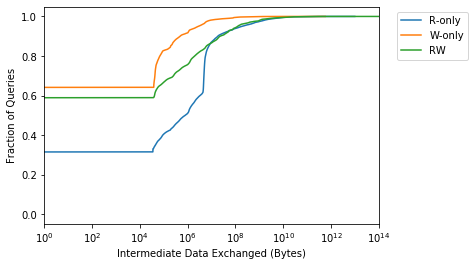

In [5]:
# Plot per-class CDFs of intermediate data exchanged over network 
plt.plot(*ecdf(df[df['ronly']]['intDataNetSentBytes']), label='R-only')
plt.plot(*ecdf(df[df['wonly']]['intDataNetSentBytes']), label='W-only')
plt.plot(*ecdf(df[df['rw']]['intDataNetSentBytes']), label='RW')
plt.gca().set_xscale('log')
plt.gca().set_xlim((1,10**14))
plt.gca().legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.gca().set_xlabel('Intermediate Data Exchanged (Bytes)')
plt.gca().set_ylabel('Fraction of Queries')

Text(0, 0.5, 'Fraction of Queries')

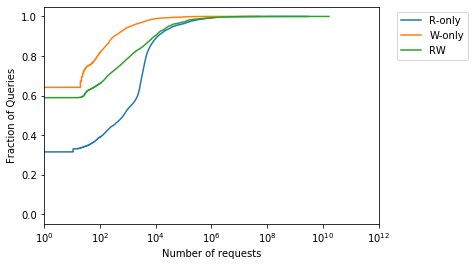

In [6]:
# Plot per-class CDFs of number of network requests for intermediate data exchange 
plt.plot(*ecdf(df[df['ronly']]['intDataNetSentRequests']), label='R-only')
plt.plot(*ecdf(df[df['wonly']]['intDataNetSentRequests']), label='W-only')
plt.plot(*ecdf(df[df['rw']]['intDataNetSentRequests']), label='RW')
plt.gca().set_xscale('log')
plt.gca().set_xlim((1,10**12))
plt.gca().legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.gca().set_xlabel('Number of requests')
plt.gca().set_ylabel('Fraction of Queries')

Text(0, 0.5, 'Fraction of Queries')

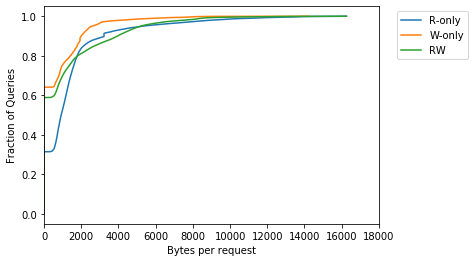

In [7]:
# Plot per-class CDFs of network request sizes for intermediate data exchange
# Plot per-class CDFs of number of network requests for intermediate data exchange 
plt.plot(*ecdf((df[df['ronly']]['intDataNetSentBytes'] / df[df['ronly']]['intDataNetSentRequests'])
               .replace([np.inf, -np.inf, np.nan], 0)), label='R-only')
plt.plot(*ecdf((df[df['wonly']]['intDataNetSentBytes'] / df[df['wonly']]['intDataNetSentRequests'])
               .replace([np.inf, -np.inf, np.nan], 0)), label='W-only')
plt.plot(*ecdf((df[df['rw']]['intDataNetSentBytes'] / df[df['rw']]['intDataNetSentRequests'])
               .replace([np.inf, -np.inf, np.nan], 0)), label='RW')
plt.gca().set_xlim((0,18000))
plt.gca().legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.gca().set_xlabel('Bytes per request')
plt.gca().set_ylabel('Fraction of Queries')

(1, 100000000000000)

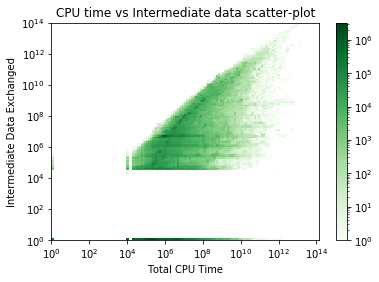

In [8]:
# Scatter-plot of CPU-time vs Intermediate data exchanged
def logScatterPlot(x, y):
    x_bins = np.logspace(np.log10(min(x)), np.log10(max(x)), 150)
    y_bins = np.logspace(np.log10(min(y)), np.log10(max(y)), 150)
    
    Z, xedges, yedges = np.histogram2d(x,y,[x_bins,y_bins])
    p = plt.pcolormesh(xedges, yedges, Z.T, norm=colors.LogNorm(vmin=1, vmax=Z.max()),
                        cmap='Greens')
    plt.gcf().colorbar(p)

    plt.yscale('log')
    plt.xscale('log')
    
    return plt.gca()

ax = logScatterPlot(df['userCpuTime'] + df['systemCpuTime'] + 1, df['intDataNetSentBytes'] + 1)
ax.set_xlabel('Total CPU Time')
ax.set_ylabel('Intermediate Data Exchanged')
ax.set_title('CPU time vs Intermediate data scatter-plot')
ax.set_ylim((1,10**14))
ax.set_ylim((1,10**14))